In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter, YearLocator
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the data
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz')

# Preprocess the data
date_time = data['date_time']
traffic_volume = data['traffic_volume']

data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
data.shape

(48204, 9)

In [ ]:

# Scale the data
scaler = MinMaxScaler()
traffic_volume_scaled = scaler.fit_transform(traffic_volume.values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(traffic_volume_scaled) * 0.8)
train_data = traffic_volume_scaled[:train_size]
test_data = traffic_volume_scaled[train_size:]



In [ ]:

# Define a function to prepare the data for LSTM
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Choose a number of time steps
n_steps = 10

# Prepare the training and testing data
X_train, y_train = prepare_data(train_data, n_steps)
X_test, y_test = prepare_data(test_data, n_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=2)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2410/2410 - 37s - 15ms/step - loss: 0.0144
Epoch 2/10
2410/2410 - 33s - 14ms/step - loss: 0.0083
Epoch 3/10
2410/2410 - 42s - 17ms/step - loss: 0.0070
Epoch 4/10
2410/2410 - 40s - 17ms/step - loss: 0.0064
Epoch 5/10
2410/2410 - 23s - 10ms/step - loss: 0.0062
Epoch 6/10
2410/2410 - 40s - 17ms/step - loss: 0.0060
Epoch 7/10
2410/2410 - 23s - 10ms/step - loss: 0.0059
Epoch 8/10
2410/2410 - 23s - 10ms/step - loss: 0.0058
Epoch 9/10
2410/2410 - 41s - 17ms/step - loss: 0.0057
Epoch 10/10
2410/2410 - 41s - 17ms/step - loss: 0.0057


In [ ]:
next_day_data = [5000, 3918, 4918, 5000, 4767, 5000, 5070, 5400, 4767, 4918]

# Assuming next_day_data contains traffic volume for the last 10 time steps

# Reshape the data for prediction
next_day_data_reshaped = np.reshape(next_day_data, (1, len(next_day_data), 1))
print(next_day_data_reshaped)

# Make prediction for the next traffic volume
predicted_volume = model.predict(next_day_data_reshaped)[0][0]

# Invert scaling (optional, if your data was scaled)
predicted_volume = scaler.inverse_transform(np.array([[predicted_volume]]))

print(f"Predicted traffic volume for the next time step: {predicted_volume}")


[[[5000]
  [3918]
  [4918]
  [5000]
  [4767]
  [5000]
  [5070]
  [5400]
  [4767]
  [4918]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Predicted traffic volume for the next time step: [[4742.025]]


301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


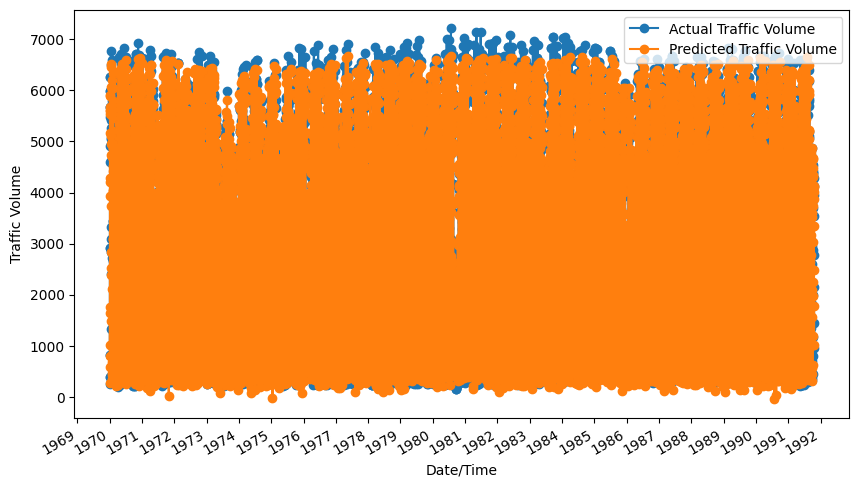

In [ ]:

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(date_time[n_steps+train_size:], traffic_volume[n_steps+train_size:],marker='o', label='Actual Traffic Volume')
plt.plot(date_time[n_steps+train_size:], predictions,marker='o', label='Predicted Traffic Volume')
plt.xlabel('Date/Time')
plt.ylabel('Traffic Volume')
plt.legend()

 # Format X-axis to show only years
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
# Rotate x-axis labels for better visibility
plt.gcf().autofmt_xdate()

plt.show()


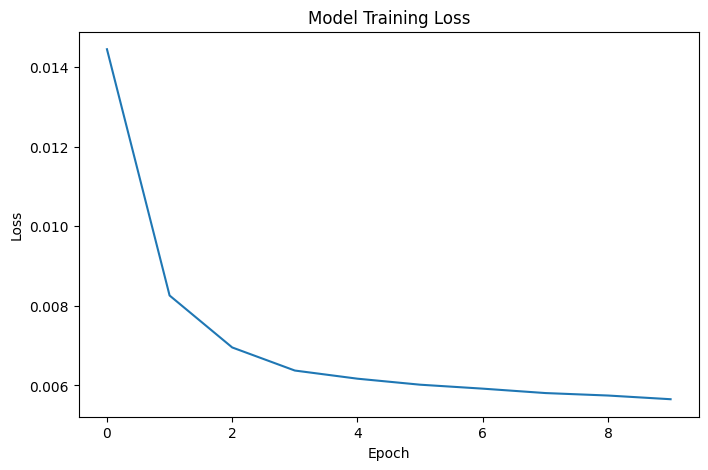

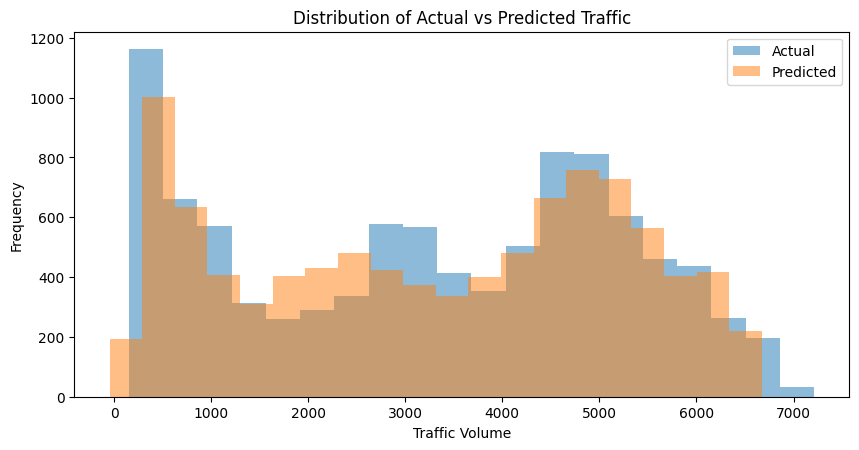

In [ ]:
# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Distribution of actual vs predicted traffic volume
plt.figure(figsize=(10, 5))
plt.hist(traffic_volume[n_steps+train_size:], bins=20, alpha=0.5, label='Actual')
plt.hist(predictions, bins=20, alpha=0.5, label='Predicted')
plt.legend()
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs Predicted Traffic')


plt.subplots_adjust(bottom=0.15)  # Adjust spacing between subplots
plt.show()

ValueError: Data must be 1-dimensional, got ndarray of shape (9631, 9631) instead

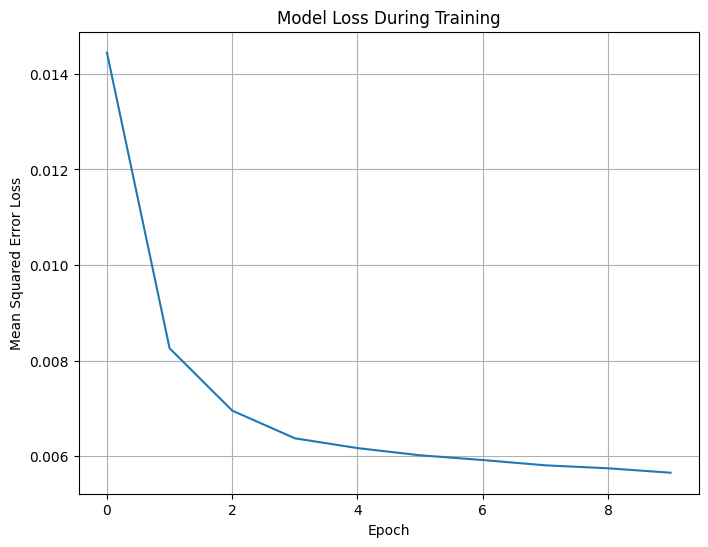

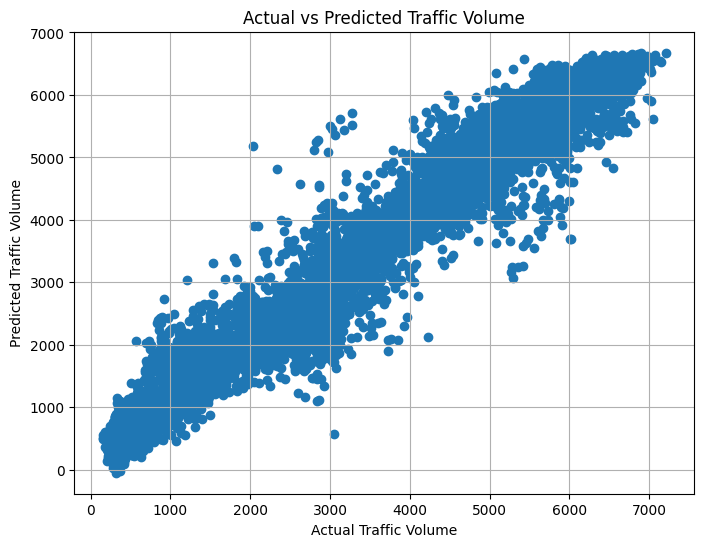

In [ ]:

# Plot loss during training
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.grid()

# Distribution of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(traffic_volume[n_steps+train_size:], predictions)
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Actual Traffic Volume')
plt.ylabel('Predicted Traffic Volume')
plt.grid()

# Error distribution (actual - predicted)
errors = predictions - traffic_volume[n_steps+train_size:]
plt.figure(figsize=(8, 6))
plt.hist(errors)
plt.title('Prediction Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid()

# Plot actual vs predicted traffic volume (zoomed in)
plt.figure(figsize=(10, 6))
plt.plot(date_time[n_steps+train_size: n_steps+train_size+50], traffic_volume[n_steps+train_size: n_steps+train_size+50],marker='o', label='Actual Traffic Volume')
plt.plot(date_time[n_steps+train_size: n_steps+train_size+50], predictions[:50],marker='o', label='Predicted Traffic Volume')
plt.xlabel('Date/Time')
plt.ylabel('Traffic Volume')
plt.legend()

# Format X-axis (similar to previous plot)
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()

plt.show()

In [ ]:
# Save the model (if desired)
model.save("traffic_flow_predictor.h5")  # Adjust filename as needed
